In [97]:
import numpy as np
import pandas as pd
import pyabf
import matplotlib.pyplot as plt
from scipy import integrate 

In [115]:
def calc_base_i(_i):
    
    return (_i[0]+_i[-1])/2

def calc_dt(t0,t1):
    
    return t1-t0

def calc_di(_base,_i,_t):
    

    I1 = integrate.simpson(_i,_t)
    
    return np.abs(_base)-np.abs(I1/(_t[-1]-_t[0]))

def calc_dioi(_di,_base):
    
    return _di/(np.abs(_base)-np.abs(_di))

def calc_vel(_dt,_L = 12.*10**-6):
    
    return (_L)/(_dt/1000.)

In [153]:
pore = 'pet2363'
particle = 'ecoli2'


raw_base = 'D://bacteria_data/raw/'+pore + '/' + particle +'/'
an_base = 'D://bacteria_data/analysis/'+pore + '/' + particle +'/'

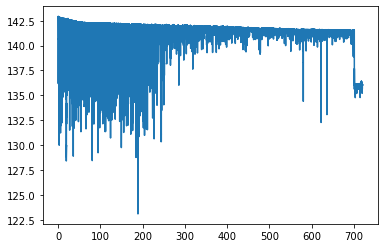

In [160]:
abf = pyabf.ABF(raw_base+'/raw/raw.abf')
abf.setSweep(0)
i = abf.sweepY
v = abf.sweepC
t = abf.sweepX

plt.plot(t,i)

In [155]:
events = pd.read_excel(raw_base+'/events/events.xlsx')
events = events.drop(events.columns[:4],axis=1)
events = events.drop(events.columns[2:],axis=1)
columns = events.columns
#events = events.rename({columns[0]:'t0',columns[1]:'t1',columns[2]:'delta_t',columns[3]:'area',
                        #columns[4]:'delta_i',columns[5]:'base_i',columns[6]:'delta_i_i'},axis=1)
events = events.rename({columns[0]:'t0',columns[1]:'t1'},axis=1)
events = events.dropna()
events.t0 = np.around(events.t0/1000.,decimals=4)
events.t1 = np.around(events.t1/1000.,decimals=4)
print(len(events))

120


In [156]:
args = []
i_events = []
velocity = []
t_events = []
baseline = []
delta_t = []
delta_i = []
delta_i_i = []
i_clean = []

for j,row in events.iterrows():
    
    arg = np.where((t>=row.t0)&(t<=row.t1))[0]
    time = t[arg]
    i_raw = i[arg]
    
    ib = calc_base_i(i_raw)
    dt = calc_dt(row.t0,row.t1)
    
    di = calc_di(ib,i_raw,time)
    dioi = calc_dioi(di,ib)
    vel = calc_vel(dt)
    
    baseline.append(ib)
    delta_t.append(dt)
    delta_i.append(di)
    delta_i_i.append(dioi)
    velocity.append(vel)
    
    args.append(arg)
    i_events.append(i_raw)
    t_events.append(time)
    i_clean.append(np.abs(i_raw)-np.abs(ib))
    
    

events['baseline'] = baseline
events['dt'] = delta_t
events['di'] = delta_i
events['di_i'] = delta_i_i
events['vel'] = velocity

events['args'] = args
events['i'] = i_events
events['i_clean'] = i_clean
events['t'] = t_events

events['voltage'] = np.median(v)
events['particle'] = particle
events['pore'] = pore

In [157]:
events.iloc[0]

t0                                                    13.6709
t1                                                    13.8368
baseline                                            142.29126
dt                                                     0.1659
di                                                   3.413631
di_i                                                  0.02458
vel                                                  0.072333
args        [136709, 136710, 136711, 136712, 136713, 13671...
i           [141.99829, 141.99219, 141.97998, 141.97998, 1...
i_clean     [-0.29296875, -0.29907227, -0.3112793, -0.3112...
t           [13.670900000000001, 13.671000000000001, 13.67...
voltage                                                   0.2
particle                                               ecoli2
pore                                                  pet2363
Name: 0, dtype: object

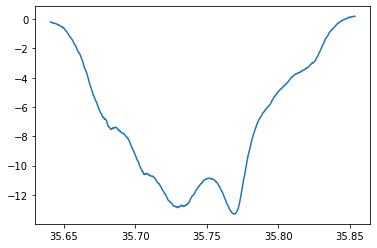

In [158]:
plt.plot(events.iloc[8].t,events.iloc[8].i_clean)

In [95]:
for j, row in events.iterrows():
    
    plt.plot(row.t,row.i_clean)
    plt.xlabel('Time (s)')
    plt.ylabel('Current (nA)')
    plt.title(particle)
    plt.tight_layout()
    plt.savefig(an_base+'event_plots/'+ particle +'_'+str(j))
    plt.close()

In [159]:
events.to_pickle(an_base+'/dataframe/df_processed.pkl')